# M2608.001300 Machine Learning <br> Assignment #2-2 backpropagation in multilayer perceptron

Copyright (C) Data Science and Artificial Intelligence Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jeonghee Jo, March 2018

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **student_id** as input argument. <br>
This will produce a zipped file called *[student_id].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; student_id)

## Load dataset

In [54]:
import pickle
import random

from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
f = open("train_images.pickle", 'rb')
train_images = pickle.load(f)
f.close()

f2 = open("train_labels.pickle", 'rb')
train_labels = pickle.load(f2)
f2.close()

g = open("test_images.pickle", 'rb')
test_images = pickle.load(g)
g.close()

g2 = open("test_labels.pickle", 'rb')
test_labels = pickle.load(g2)
g2.close()

In [56]:
print("train images shape: ", train_images.shape)
print("train labels shape: ", train_labels.shape)
print("test images shape: ", test_images.shape)
print("test labels shape: ", test_labels.shape)

train images shape:  (10000, 28, 28)
train labels shape:  (10000,)
test images shape:  (5000, 28, 28)
test labels shape:  (5000,)


In [57]:
num_training = train_images.shape[0]
num_test = test_images.shape[0]
image_size = train_images.shape[1]

print("num_training: ", num_training)
print("num_test: ", num_test)
print("image_size: ", image_size)

num_training:  10000
num_test:  5000
image_size:  28


Train filtering 0.0
Train filtering 1.0
Train filtering 2.0
Train filtering 3.0
Train filtering 4.0
Train filtering 5.0
Train filtering 6.0
Train filtering 7.0
Train filtering 8.0
Train filtering 9.0
Test filtering 0.0
Test filtering 1.0
Test filtering 2.0
Test filtering 3.0
Test filtering 4.0


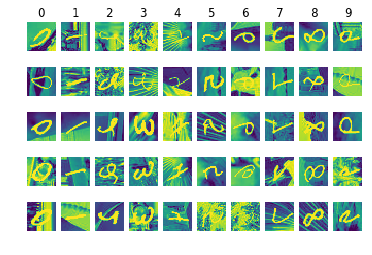

In [58]:
##PREPROCESSING
##Filter out noice using threshold function

train_temp = np.zeros((train_images.shape[0], train_images.shape[1], train_images.shape[2]))
test_temp = np.zeros((test_images.shape[0], test_images.shape[1], test_images.shape[2]))

for i in range(num_training):
    img = train_images[i]
    img_t = train_temp[i]
    
    for x in range(28):
        for y in range(28):
            if img[x][y]>0.97:
                img_t[x][y] = 1.0
            else:
                img_t[x][y] = 0.0
            
                
    if i%1000 == 0:
        print("Train filtering", i/1000)

for i in range(num_test):
    img = test_images[i]
    img_t = test_temp[i]
    
    for x in range(26):
        for y in range(26):
            if img[x][y]>0.97:
                img_t[x][y] = 1.0
            else:
                img_t[x][y] = 0.0
            
    if i%1000 == 0:
        print("Test filtering", i/1000)



classes = list(range(10))

num_classes = 10
sample_per_class = 5
np.random.seed(0)

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        plt.imshow(train_images[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

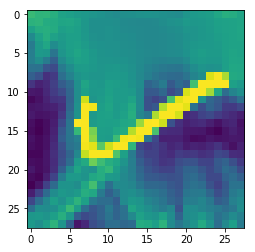

In [59]:
#Preprocessing test
plt.imshow(train_images[9])

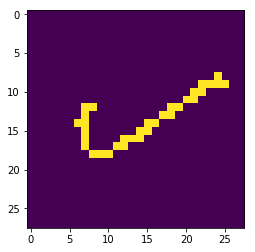

In [60]:
#Preprocessing test
plt.imshow(train_temp[9])

## Preprocessing

In [61]:
train_images = train_temp
test_images = test_temp

train_images = np.reshape(train_images, (np.array(train_images).shape[0], -1))
test_images = np.reshape(test_images, (np.array(test_images).shape[0], -1))

print("Training data shape: ", train_images.shape)
print("Test data shape: ", test_images.shape)

Training data shape:  (10000, 784)
Test data shape:  (5000, 784)


[0.0155 0.014  0.0138 0.0123 0.0127 0.0129 0.0141 0.013  0.0121 0.0118]


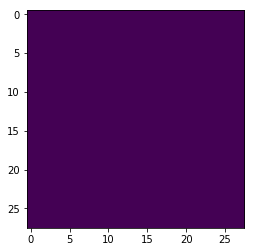

In [62]:
mean_image = np.mean(train_images, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8'))
plt.show()

In [63]:
train_images -= mean_image
test_images -= mean_image

train_images = train_images.reshape((-1, image_size * image_size)).astype(np.float32)
test_images = test_images.reshape((-1, image_size * image_size)).astype(np.float32)
train_labels = (np.arange(num_classes) == train_labels[:,None]).astype(np.float32)
test_labels = (np.arange(num_classes) == test_labels[:,None]).astype(np.float32)

print("train_images", train_images.shape)
print("train_labels", train_labels.shape)
print("test_images", test_images.shape)
print("test_labels", test_labels.shape)
#print(train_labels)

train_images (10000, 784)
train_labels (10000, 10)
test_images (5000, 784)
test_labels (5000, 10)


## Training a Neural Network

<b><font color='blue'>one input layer + one hidden layer + one output layer</font></b>

The number of nodes in the <b>input lyaer</b>: <b><font color='red'>784</font></b> (the dimensionality of the data) <br>
The number of nodes in the <b>output layer</b>: <b><font color='red'>10</font></b> (the number of classes)
    
The input to the network: the pixel values of the input images<br>
The output from the network: ten probabilities, one for each class

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$<br>
$a_i$ is the output of layer $i$ after applying the activation function<br> 
$W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices.<br>
If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.

Applying the backpropagation formula we find the following (trust me on this):

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

## Build model <br> (1) 1-hidden layer neural network

### Loss function

In [17]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    z1 = train_images.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    corect_logprobs = -np.log([probs[i,np.nonzero(train_labels)[(1)][i].astype('int64')] for i in range(num_training)])
    data_loss = np.sum(corect_logprobs)

    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_training * data_loss

### Prediction function (for test dataset)

In [18]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

### Implementation

In [19]:
nn_input_dim = 784 # input layer dimensionality
nn_output_dim = 10 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

---
### <font color=blue>[Problem #1]</font> (10 points)
1. Complete "Backpropagation" part in the <i><b>build_model</b></i>

In [22]:
def build_model(nn_hdim, num_passes=2000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):
        # Forward propagation
        
        z1 = train_images.dot(W1) + b1
        a1 = np.tanh(z1)
        #a1 = 1.0/(1.0+np.exp(-z1))
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        #print(probs.shape)
        #print(a1.shape)
        
        # Backpropagation
        #
        # TO DO (complete below assignments)
        #
        insz = train_labels.shape[0]
        delta3 = probs - train_labels
        dW2 = np.matmul(a1.T, delta3) * (1/insz)
        db2 = np.sum(delta3, axis=0, keepdims=True) * (1/insz)
        delta2 = (1-np.power(a1,2))*(np.matmul(delta3, W2.T)) 
        
        #delta2 = a1*(1-a1)*(np.matmul(delta3, W2.T)) 
        dW1 = np.matmul(train_images.T, delta2) * (1/insz)
        db1 = np.sum(delta2, axis=0) * (1/insz)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        #print(model)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 100 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

In [23]:
model = build_model(32, print_loss=True, num_passes=2000)

Loss after iteration 0: 2.329714
Loss after iteration 100: 1.973988
Loss after iteration 200: 1.733305
Loss after iteration 300: 1.554130
Loss after iteration 400: 1.413957
Loss after iteration 500: 1.301417
Loss after iteration 600: 1.209524
Loss after iteration 700: 1.133619
Loss after iteration 800: 1.070373
Loss after iteration 900: 1.017242
Loss after iteration 1000: 0.972222
Loss after iteration 1100: 0.933725
Loss after iteration 1200: 0.900507
Loss after iteration 1300: 0.871590
Loss after iteration 1400: 0.846210
Loss after iteration 1500: 0.823766
Loss after iteration 1600: 0.803780
Loss after iteration 1700: 0.785871
Loss after iteration 1800: 0.769733
Loss after iteration 1900: 0.755116


### Prediction of test dataset

In [24]:
pred = predict(model, test_images)

In [25]:
pred_accuracy = np.sum(pred == np.argmax(test_labels, axis=1))/len(pred) 
print("prediction accuracy: ", '{0:.2f}'.format(pred_accuracy*100), "%")

prediction accuracy:  80.00 %


---
### <font color=blue>[Problem #2]</font> (60 points)

<b>Implement a new neural network with <u><font color='blue'>more than one hidden layer.</font></u><br>
Define and optimize parameters for higer accuracy.<br>
    <font color='red'>Do NOT use </font>other classifiers.</b>

1. Complete the function <i><b>my_calculate_loss</b></i> (5pt)
2. Complete the function <i><b>my_predict</b></i> (5pt)
3. Define several parameters (input/hidden/output network dimensions, regularizers, ...) (5pt)
4. Complete the function <i><b>my_build_model</b></i> (20pt)
5. <b>Predict the new test set(<i><font color='blue'>test_for_scoring</font></i>) with the model from <i>my_build_model</i></b>. (25 pt)<br>
<b>****The label of <i><font color='blue'>test_for_scoring</font></i> will <font color='red'>not be provided. </font><br>
**** <font color='red'>Prediction accuracy </font>will be evaluated.</b>

## Build model <br> (2) multi-hidden layer neural network

In [65]:
#ACTIVATION FUNCTIONS
#sigmoid, tanh, ReLU, leaky ReULU
def act_ftn(x, op):
    if op==0 :
        return 1.0/(1.0+np.exp(-x))
    if op==1 :
        return np.tanh(x)
    if op==2 :
        return np.maximum(x,0)
    return np.maximum(x, 0.01*x)


#Softmax Function
def softmax(x):
    probs = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
    return probs


def my_calculate_loss(model):
    #
    # TO DO
    W = model['W']
    b = model['b']
    op = model['op']
    num_hid = model['num_hid']
    train_dataset = train_images
    #print(train_dataset.shape)
    s = []
    z = []
        
    #hiddent1 layer
    for i in range(num_hid+1):
        #print(W[i].shape)
        if i == 0:
            s_temp = np.matmul(train_dataset, W[0]) + b[0]
            z_temp = act_ftn(s_temp, op)
            #z_temp = np.c_[np.ones(data_size), z_temp]
        
        elif i == num_hid:
            s_temp = np.matmul(z[i-1], W[i]) + b[i]
            z_temp = softmax(s_temp)
            
        else:
            s_temp = np.matmul(z[i-1], W[i]) + b[i]
            z_temp = act_ftn(s_temp, op)
            #z_temp = np.c_[np.ones(data_size), z_temp]
        
        s.append(s_temp)
        z.append(z_temp)
        
    probs = z[num_hid]
    #print(probs)
    
    corect_logprobs = -np.log([probs[i,np.nonzero(train_labels)[(1)][i].astype('int64')] for i in range(num_training)])
    data_loss = np.sum(corect_logprobs)
    
    for _w in W:
        data_loss += reg_lambda/2 * np.sum(np.square(_w))
    return 1./num_training * data_loss
    

In [66]:
def my_predict(model, x):
    #
    # TO DO
    #
    W = model['W']
    b = model['b']
    op = model['op']
    num_hid = model['num_hid']
    N = x.shape[0]
    
    s = []
    z = []
        
    #hiddent1 layer
    for i in range(num_hid+1):
        #print(W[i].shape)
        if i == 0:
            s_temp = np.matmul(x, W[0]) + b[0]
            z_temp = act_ftn(s_temp, op)
        
        elif i == num_hid:
            s_temp = np.matmul(z[i-1], W[i]) + b[i]
            z_temp = softmax(s_temp)
            
        else:
            s_temp = np.matmul(z[i-1], W[i]) + b[i]
            z_temp = act_ftn(s_temp, op)
        
        s.append(s_temp)
        z.append(z_temp)
        
    probs = z[num_hid]
    #print(probs)
    
    return np.argmax(probs, axis=1)

In [67]:
# Define network dimensions (input, hidden, output, ...), regularizer parameter(reg_lambda, epsilon), ... 
#
# TO DO
#
in_dim = 784 # input layer dimensionality
out_dim = 10 # output layer dimensionality
hid_dim = [256, 256]

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [68]:
data_size = train_labels.shape[0]
test_size = test_labels.shape[0]

batch_size = int(data_size/30) ############ You can change it ############

"""
train_images = train_images.reshape((-1, image_size * image_size)).astype(np.float32)
test_images = test_images.reshape((-1, image_size * image_size)).astype(np.float32)
train_labels = (np.arange(num_classes) == train_labels[:,None]).astype(np.float32)
test_labels = (np.arange(num_classes) == test_labels[:,None]).astype(np.float32)
"""


def my_build_model(num_passes=1000, print_loss=True, op=0): # TO DO - Add more arguments and you can change num_passes ######################
    
    np.random.seed(0)

    # Initialize the parameters to random values. We need to learn these.
    #
    # TO DO
    
    # preprocessing
    train_dataset = train_images 
    test_dataset = np.ones(test_size), test_images
    
    num_hid = len(hid_dim)
    print('hidden layer =', hid_dim, 'epsilon =', epsilon, 'reg_lambda =', reg_lambda)
    
    W = []
    dW = []
    b = []
    db = []
    
    for i in range(num_hid+1):
        
        if i==0 :
            W_temp = np.random.randn(in_dim+0, hid_dim[i]) / np.sqrt(in_dim+0)
            dW_temp = np.zeros((in_dim+0, hid_dim[i]))
            b_temp = np.zeros((1, hid_dim[i]))
            db_temp = np.zeros((1, hid_dim[i]))
        elif i==num_hid :
            W_temp = np.random.randn(hid_dim[i-1]+0, out_dim) / np.sqrt(hid_dim[i-1]+0)
            dW_temp = np.zeros((hid_dim[i-1]+0, out_dim))
            b_temp = np.zeros((1, out_dim))
            db_temp = np.zeros((1, out_dim))
        else :
            W_temp = np.random.randn(hid_dim[i-1]+0, hid_dim[i]) / np.sqrt(hid_dim[i-1]+0)
            dW_temp = np.zeros((hid_dim[i-1]+0, hid_dim[i]))
            b_temp = np.zeros((1, hid_dim[i]))
            db_temp = np.zeros((1, hid_dim[i]))
            
        W.append(W_temp)
        dW.append(dW_temp)
        b.append(b_temp)
        db.append(db_temp)
    
    
    # This is what we return at the end
    g_model = {}
    model = {}
    g_acc = 0
    
    # Gradient descent. For each batch...
    for k in range(0, num_passes):

        # minibatch implementation
        minibatch_index = random.sample(range(1, data_size), batch_size)
        minibatch = np.array(train_dataset[minibatch_index])
        minibatch_labels = np.array(train_labels[minibatch_index])
        
        # Forward propagation
        #
        # TO DO
        
        s = []
        z = []
        
        #hiddent1 layer
        for i in range(num_hid+1):
            #print(W[i].shape)
            if i == 0:
                s_temp = np.matmul(minibatch, W[0]) + b[0]
                z_temp = act_ftn(s_temp, op)
            
            elif i == num_hid:
                s_temp = np.matmul(z[i-1], W[i]) + b[i]
                z_temp = softmax(s_temp)
                
            else:
                s_temp = np.matmul(z[i-1], W[i]) + b[i]
                z_temp = act_ftn(s_temp, op)
            
            s.append(s_temp)
            z.append(z_temp)
       
        
        Z = z[num_hid]
      
        # Backpropagation
        #
        # TO DO
        
        err = Z - minibatch_labels 
             
        
        #output layer
        
        dW[num_hid] = np.matmul(z[num_hid-1].T, err) * (1/batch_size)
        
        #hidden layers
        
        for j in range(num_hid):
            i = num_hid-1-j
            
            if i!=0 :
                if op==0:
                    err = z[i]*(1.0-z[i])*(np.matmul(err, W[i+1].T))
                elif op==1:
                    err = (1-np.power(z[i], 2))*(np.matmul(err, W[i+1].T))
                elif op==2:
                    err = (np.maximum(z[i], 0)/(z[i]+0.001))*(np.matmul(err, W[i+1].T))
                else:
                    err = (np.maximum(z[i], 0.01*z[i])/z[i])*(np.matmul(err, W[i+1].T)) 
                
                dW[i] = np.matmul(z[i-1].T, err) * (1/batch_size)
                db[i] = np.sum(err, axis=0, keepdims=True) * (1/batch_size)
                
            else:
                
                #print(i)
                if op==0 :
                    err = z[i]*(1.0-z[i])*(np.matmul(err, W[i+1].T))
                elif op==1:
                    err = (1-np.power(z[i], 2))*(np.matmul(err, W[i+1].T))
                elif op==2:
                    err = (np.maximum(z[i], 0)/(z[i]+0.001))*(np.matmul(err, W[i+1].T))
                else:
                    err = (np.maximum(z[i], 0.01*z[i])/z[i])*(np.matmul(err, W[i+1].T)) 
                    
                dW[i] = np.matmul(minibatch.T, err) * (1/batch_size)
                db[i] = np.sum(err, axis=0) * (1/batch_size)
        
        #

        # Add regularization terms (b1 and b2 don't have regularization terms)
        #
        # TO DO
        for i in range(len(W)):
            dW[i] += reg_lambda*W[i]
        #
        
        # Gradient descent parameter update
        #
        # TO DO
        for i in range(len(W)):
            W[i] += -epsilon*dW[i]
            b[i] += -epsilon*db[i]
        #
        
        # Assign new parameters to the model
        #
        # TO DO
        model['W'] = W
        model['b'] = b
        model['op'] = op
        model['num_hid'] = num_hid 
        
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and k % 2000 == 0:
            print("Loss after iteration %i: %f" %(k, my_calculate_loss(model)))
            
            pred = my_predict(model, test_images)
            pred_accuracy = np.sum(pred == np.argmax(test_labels, axis=1))/len(pred) 
            print("prediction accuracy: ", '{0:.2f}'.format(pred_accuracy*100), "%")
        
        if k % 1000 == 0:
            pred = my_predict(model, test_images)
            pred_accuracy = np.sum(pred == np.argmax(test_labels, axis=1))/len(pred) 
            print(k, '{0:.2f}'.format(pred_accuracy*100), "%")
            
            if g_acc<pred_accuracy:
                g_model = model
                g_acc = pred_accuracy
        
    
    print("Final :", '{0:.2f}'.format(g_acc*100), "%")
    return g_model

In [16]:
"""
epsilons = [0.04, 0.06, 0.08]
hiddens = [(512, 256), (512, 512)]
reg_lambdas = [0.003, 0.0035, 0.004]
results = {}
batch_size = int(data_size/30)


## Search and Find the Best Hyperparameter!!

for h in hiddens:
    for rl in reg_lambdas:
        for e in epsilons:
            hid_dim = h
            epsilon = e # learning rate for gradient descent
            reg_lambda = rl
            
            my_model = my_build_model(num_passes=100001, print_loss=False, op=2)
            
            pred = my_predict(my_model, test_images)
            pred_accuracy = np.sum(pred == np.argmax(test_labels, axis=1))/len(pred) 
            print()
            results[(h,e)]= (my_model, pred_accuracy)
            
"""

hidden layer = (512, 256) epsilon = 0.04 reg_lambda = 0.003
0 11.30 %
1000 84.20 %
2000 86.16 %
3000 87.08 %
4000 87.78 %
5000 87.76 %
6000 87.86 %
7000 87.80 %
8000 87.84 %
9000 88.08 %
10000 88.18 %
11000 88.02 %
12000 88.24 %
13000 88.32 %
14000 88.40 %
15000 88.28 %
16000 88.60 %
17000 88.34 %
18000 88.40 %
19000 88.32 %
20000 88.48 %
21000 88.64 %
22000 88.46 %
23000 88.66 %
24000 88.64 %
25000 88.90 %
26000 88.88 %
27000 88.90 %
28000 88.92 %
29000 88.84 %
30000 88.80 %
31000 88.98 %
32000 89.00 %
33000 89.00 %
34000 89.14 %
35000 89.14 %
36000 88.98 %
37000 89.00 %
38000 88.96 %
39000 89.04 %
40000 89.08 %
41000 88.88 %
42000 88.94 %
43000 89.06 %
44000 89.08 %
45000 89.10 %
46000 89.06 %
47000 88.94 %
48000 88.98 %
49000 89.04 %
50000 89.10 %
51000 89.10 %
52000 89.20 %
53000 89.04 %
54000 89.16 %
55000 89.16 %
56000 89.06 %
57000 89.06 %
58000 89.06 %
59000 89.14 %
60000 89.20 %
61000 89.18 %
62000 89.06 %
63000 89.12 %
64000 89.14 %
65000 89.16 %
66000 89.16 %
67000 89.14 %
6

54000 89.16 %
55000 88.92 %
56000 89.06 %
57000 88.88 %
58000 89.00 %
59000 89.02 %
60000 88.94 %
61000 88.98 %
62000 89.12 %
63000 89.02 %
64000 89.14 %
65000 89.12 %
66000 88.98 %
67000 89.12 %
68000 89.00 %
69000 89.08 %
70000 89.10 %
71000 89.04 %
72000 89.12 %
73000 89.10 %
74000 89.10 %
75000 89.10 %
76000 88.96 %
77000 88.98 %
78000 88.98 %
79000 89.24 %
80000 89.24 %
81000 89.06 %
82000 88.90 %
83000 89.12 %
84000 89.26 %
85000 88.96 %
86000 89.26 %
87000 89.14 %
88000 89.20 %
89000 89.02 %
90000 89.12 %
91000 89.20 %
92000 89.24 %
93000 89.12 %
94000 89.16 %
95000 89.06 %
96000 88.82 %
97000 89.14 %
98000 89.00 %
99000 89.18 %
100000 89.16 %
Final : 89.26 %

hidden layer = (512, 256) epsilon = 0.04 reg_lambda = 0.004
0 11.24 %
1000 84.20 %
2000 86.12 %
3000 86.84 %
4000 87.42 %
5000 87.76 %
6000 87.74 %
7000 87.54 %
8000 87.64 %
9000 88.02 %
10000 87.86 %
11000 88.12 %
12000 88.24 %
13000 88.38 %
14000 88.20 %
15000 88.40 %
16000 88.34 %
17000 88.44 %
18000 88.40 %
19000 88.52

5000 87.94 %
6000 88.28 %
7000 88.08 %
8000 88.48 %
9000 88.62 %
10000 88.78 %
11000 88.66 %
12000 88.74 %
13000 88.80 %
14000 88.92 %
15000 88.76 %
16000 88.94 %
17000 88.76 %
18000 88.90 %
19000 88.94 %
20000 88.82 %
21000 88.92 %
22000 88.84 %
23000 88.92 %
24000 88.92 %
25000 88.84 %
26000 88.98 %
27000 89.02 %
28000 88.92 %
29000 88.98 %
30000 88.98 %
31000 89.06 %
32000 88.92 %
33000 89.00 %
34000 89.00 %
35000 88.90 %
36000 89.04 %
37000 89.00 %
38000 89.02 %
39000 88.90 %
40000 88.78 %
41000 89.18 %
42000 88.96 %
43000 88.76 %
44000 89.06 %
45000 88.98 %
46000 88.94 %
47000 88.94 %
48000 88.88 %
49000 88.98 %
50000 89.02 %
51000 89.02 %
52000 88.96 %
53000 89.04 %
54000 89.10 %
55000 88.94 %
56000 89.06 %
57000 89.00 %
58000 89.06 %
59000 88.92 %
60000 89.06 %
61000 89.10 %
62000 89.08 %
63000 88.86 %
64000 89.00 %
65000 89.10 %
66000 88.96 %
67000 89.28 %
68000 89.04 %
69000 89.12 %
70000 88.96 %
71000 89.00 %
72000 89.00 %
73000 89.22 %
74000 89.14 %
75000 89.02 %
76000 89.02

63000 89.16 %
64000 88.98 %
65000 88.98 %
66000 88.94 %
67000 88.88 %
68000 89.02 %
69000 88.82 %
70000 88.90 %
71000 88.96 %
72000 88.96 %
73000 89.00 %
74000 88.92 %
75000 88.86 %
76000 88.92 %
77000 88.92 %
78000 88.84 %
79000 88.94 %
80000 88.86 %
81000 88.90 %
82000 88.96 %
83000 88.84 %
84000 88.84 %
85000 88.76 %
86000 88.90 %
87000 89.12 %
88000 89.00 %
89000 88.96 %
90000 88.92 %
91000 88.86 %
92000 89.00 %
93000 88.94 %
94000 88.92 %
95000 88.92 %
96000 89.00 %
97000 88.90 %
98000 89.02 %
99000 88.80 %
100000 89.00 %
Final : 89.16 %

hidden layer = (512, 512) epsilon = 0.08 reg_lambda = 0.004
0 11.82 %
1000 86.02 %
2000 87.38 %
3000 87.86 %
4000 88.12 %
5000 88.24 %
6000 88.54 %
7000 88.38 %
8000 88.50 %
9000 88.72 %
10000 88.58 %
11000 88.70 %
12000 88.72 %
13000 88.84 %
14000 88.88 %
15000 88.82 %
16000 88.94 %
17000 88.74 %
18000 88.96 %
19000 88.80 %
20000 88.86 %
21000 88.68 %
22000 88.92 %
23000 88.88 %
24000 88.82 %
25000 88.98 %
26000 88.98 %
27000 89.00 %
28000 89.00

In [69]:
hid_dim = (512, 256) 
epsilon = 0.04 
reg_lambda = 0.004
my_model = my_build_model(num_passes=100001, print_loss=False, op=2)

hidden layer = (512, 256) epsilon = 0.04 reg_lambda = 0.004
0 11.40 %
1000 84.24 %
2000 86.18 %
3000 87.04 %
4000 87.52 %
5000 87.82 %
6000 87.76 %
7000 87.78 %
8000 87.76 %
9000 87.88 %
10000 88.04 %
11000 88.24 %
12000 88.14 %
13000 88.34 %
14000 88.18 %
15000 88.46 %
16000 88.48 %
17000 88.46 %
18000 88.70 %
19000 88.56 %
20000 88.84 %
21000 88.80 %
22000 88.74 %
23000 88.72 %
24000 88.80 %
25000 88.86 %
26000 88.88 %
27000 88.80 %
28000 88.80 %
29000 88.94 %
30000 88.92 %
31000 88.94 %
32000 88.88 %
33000 88.96 %
34000 88.94 %
35000 89.12 %
36000 88.84 %
37000 89.04 %
38000 89.08 %
39000 88.94 %
40000 89.08 %
41000 88.94 %
42000 89.02 %
43000 89.00 %
44000 89.02 %
45000 89.08 %
46000 89.28 %
47000 89.08 %
48000 89.02 %
49000 89.14 %
50000 89.22 %
51000 89.20 %
52000 89.10 %
53000 89.12 %
54000 89.16 %
55000 89.24 %
56000 89.38 %
57000 89.14 %
58000 89.26 %
59000 89.24 %
60000 89.18 %
61000 89.16 %
62000 89.12 %
63000 89.04 %
64000 89.06 %
65000 89.14 %
66000 89.16 %
67000 89.24 %
6

In [71]:
f = open("test_images_for_scoring.pickle", 'rb')
test_scoring = pickle.load(f)
f.close()

print("test_for_scoring images shape: ", test_scoring.shape)

test_for_scoring images shape:  (5000, 28, 28)


In [72]:
#Preprocessing for the test_for_scoring images
test_scoring_temp = np.zeros((test_scoring.shape[0], test_scoring.shape[1], test_scoring.shape[2]))
num_scoring = test_scoring.shape[0]

for i in range(num_scoring):
    img = test_scoring[i]
    img_t = test_scoring_temp[i]
    
    for x in range(28):
        for y in range(28):
            if img[x][y]>0.97:
                img_t[x][y] = 1.0
            else:
                img_t[x][y] = 0.0
            
                
    if i%1000 == 0:
        print("Train filtering", i/1000)

Train filtering 0.0
Train filtering 1.0
Train filtering 2.0
Train filtering 3.0
Train filtering 4.0


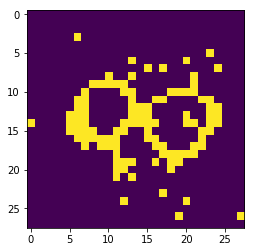

In [73]:
plt.imshow(test_scoring_temp[4])

8


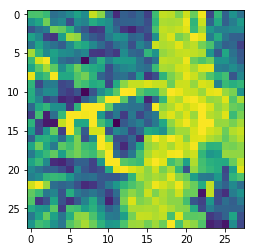

In [380]:
i = i+1
print(my_pred[i])
plt.imshow(test_scoring[i])

In [75]:
test_for_scoring = test_scoring_temp
test_for_scoring = np.reshape(test_for_scoring, (np.array(test_for_scoring).shape[0], -1))

print("Training Scoring data shape: ", test_for_scoring.shape)
mean_image = np.mean(test_for_scoring)

Training Scoring data shape:  (5000, 784)


In [76]:
test_for_scoring -= mean_image

test_for_scoring = test_for_scoring.reshape((-1, image_size * image_size)).astype(np.float32)

print("test_for_scoring", test_for_scoring.shape)


test_for_scoring (5000, 784)


In [79]:
my_pred = my_predict(my_model, test_for_scoring)